# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

model: ring in front of diffuse oscillating component and noise

In [38]:
DEVICE = 'cpu'#'cuda:0'
NDIM = 7 # number of parameters
SIGMA = 0.03

In [42]:
# A toy model with a diffuse and point source component

def model(z):
    grid = np.linspace(0, 1, 50, 50)
    X, Y = np.meshgrid(grid, grid)
    x01, y01, r1, w1,fx,fy,Amp = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05,\
        z[4]*6*np.pi,z[5]*6*np.pi,z[6]
    
    
    R1 = ((X-x01)**2 + (Y-y01)**2)**0.5+0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    
    mu = np.exp(-(R1-r1)**2/w1**2/2)
    x = mu
    return x

In [43]:
def noisemodel(x, z = None, noiselevel = 1.):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

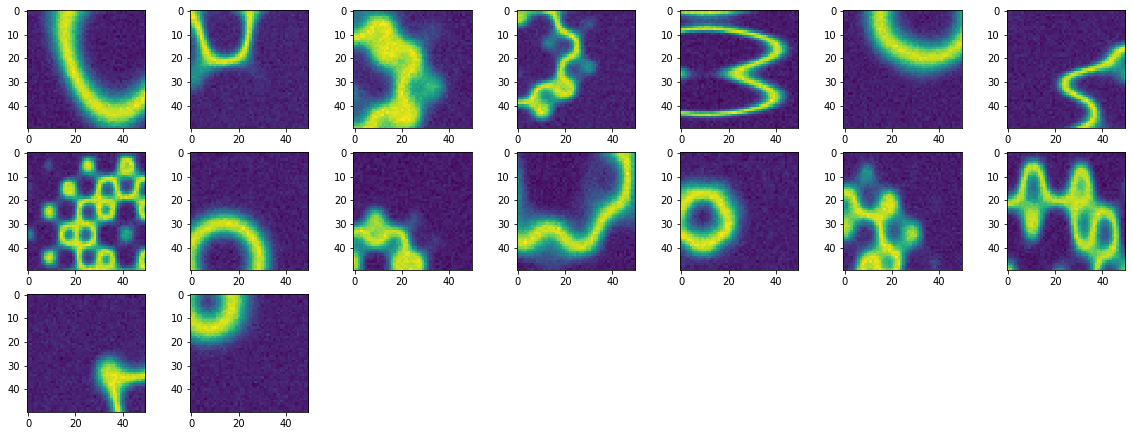

In [44]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 7, i+1)
    z = np.random.rand(9)
    x = model(z)
    x = noisemodel(x)
    plt.imshow(x)

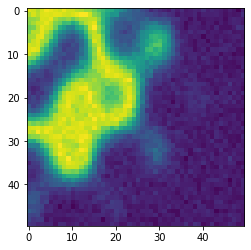

In [45]:
z0 = np.array([0.1, 0.3, 0.2, 0.8,0.8,0.6,0.5])
x0 = noisemodel(model(z0))
plt.imshow(x0)

In [46]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00062119 0.00044567 0.00105484 0.00261115 0.00050286 0.00045257
 0.00193485]


In [47]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(1, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [12]:
import time

In [48]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 2, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 2507/2507 [00:00<00:00, 52013.34it/s]


Adding 2507 new samples.


Extracting samples.: 100%|██████████| 2507/2507 [00:00<00:00, 38254.47it/s]


Extracted 2507 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 10
Validation losses: [18.947878122329712, 17.98932433128357, 17.122510373592377, 16.657101154327393, 16.669737339019775, 16.31781417131424, 16.475546777248383, 15.84747862815857, 16.016172349452972, 16.126284062862396]
LR iteration 1
Total epochs: 3
Validation losses: [15.31841516494751, 15.453421652317047, 15.57157039642334]
LR iteration 2
Total epochs: 5
Validation losses: [15.322519063949585, 15.34361845254898, 15.318071603775024, 15.335650026798248, 15.368431687355042]


Adding samples.: 100%|██████████| 2479/2479 [00:00<00:00, 33649.67it/s]


Adding 1016 new samples.


Extracting samples.: 100%|██████████| 3523/3523 [00:00<00:00, 33500.34it/s]


Extracted 2526 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 10
Validation losses: [18.34366250038147, 17.312684535980225, 16.460355281829834, 16.33314299583435, 15.836712181568146, 15.681817293167114, 15.29930567741394, 15.130888044834137, 15.402975499629974, 16.141402304172516]
LR iteration 1
Total epochs: 3
Validation losses: [14.659898459911346, 14.727974474430084, 14.81959980726242]
LR iteration 2
Total epochs: 4
Validation losses: [14.577692925930023, 14.553798139095306, 14.595423877239227, 14.59742021560669]
22.15018379688263


In [52]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 1, nsamples = 4000, nbatch = 32, recycle_net = False, threshold = 1e-8)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 4051/4051 [00:00<00:00, 23479.85it/s]


Adding 2453 new samples.


Extracting samples.: 100%|██████████| 5976/5976 [00:00<00:00, 25416.60it/s]


Extracted 4017 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 7
Validation losses: [17.45275127887726, 15.721445739269257, 14.977404773235321, 14.679275572299957, 14.254033088684082, 13.897836565971375, 13.90419089794159]
LR iteration 1
Total epochs: 3
Validation losses: [13.147499740123749, 13.064897179603577, 13.093710601329803]
LR iteration 2
Total epochs: 2
Validation losses: [13.065801799297333, 13.100665926933289]


Adding samples.: 100%|██████████| 4043/4043 [00:00<00:00, 16295.53it/s]


Adding 613 new samples.


Extracting samples.: 100%|██████████| 6589/6589 [00:00<00:00, 19044.18it/s]


Extracted 4024 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 9
Validation losses: [17.427267909049988, 16.14021247625351, 15.026977717876434, 14.563984751701355, 14.190324246883392, 14.091014325618744, 13.823144137859344, 13.819314181804657, 14.400531232357025]
LR iteration 1
Total epochs: 2
Validation losses: [13.050978481769562, 13.107425391674042]
LR iteration 2
Total epochs: 4
Validation losses: [13.043262243270874, 13.025024116039276, 12.996557593345642, 13.012878477573395]
29.51080402135849


In [54]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 6, max_epochs = 20, early_stopping_patience = 1, nsamples = 4000, nbatch = 32, recycle_net = False, threshold = 1e-8)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 3873/3873 [00:00<00:00, 17315.47it/s]


Adding 1668 new samples.


Extracting samples.: 100%|██████████| 8257/8257 [00:00<00:00, 19629.52it/s]


Extracted 3957 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 6
Validation losses: [16.940043807029724, 15.362416326999664, 14.704564571380615, 14.351546227931976, 13.571985423564911, 13.575759649276733]
LR iteration 1
Total epochs: 5
Validation losses: [12.822600305080414, 12.680521488189697, 12.605670928955078, 12.578387320041656, 12.630004942417145]
LR iteration 2
Total epochs: 2
Validation losses: [12.459281623363495, 12.482771277427673]


Adding samples.: 100%|██████████| 4012/4012 [00:00<00:00, 13547.88it/s]


Adding 2768 new samples.


Extracting samples.: 100%|██████████| 11025/11025 [00:00<00:00, 17726.22it/s]


Extracted 4084 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 7
Validation losses: [15.806427359580994, 14.042762160301208, 12.893286943435669, 12.136539340019226, 12.040332615375519, 11.30725246667862, 11.406091511249542]
LR iteration 1
Total epochs: 3
Validation losses: [10.559723198413849, 10.414723515510559, 10.449045479297638]
LR iteration 2
Total epochs: 2
Validation losses: [10.434189558029175, 10.466119527816772]


Adding samples.: 100%|██████████| 4061/4061 [00:00<00:00, 13678.94it/s]


Adding 3332 new samples.


Extracting samples.: 100%|██████████| 14357/14357 [00:00<00:00, 16684.39it/s]


Extracted 4076 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 8
Validation losses: [14.821578681468964, 13.135747730731964, 12.502237200737, 11.606747388839722, 10.807782232761383, 10.5973442196846, 10.353660225868225, 10.504538357257843]
LR iteration 1
Total epochs: 4
Validation losses: [9.190642893314362, 9.058635294437408, 8.99300754070282, 9.029066324234009]
LR iteration 2
Total epochs: 2
Validation losses: [8.807352185249329, 8.839913666248322]


Adding samples.: 100%|██████████| 3977/3977 [00:00<00:00, 11780.38it/s]


Adding 3939 new samples.


Extracting samples.: 100%|██████████| 18296/18296 [00:01<00:00, 15406.35it/s]


Extracted 3974 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 5
Validation losses: [10.76566594839096, 9.055543392896652, 8.70668551325798, 7.887789636850357, 8.154380887746811]
LR iteration 1
Total epochs: 4
Validation losses: [6.141673743724823, 5.88620300590992, 5.761172369122505, 5.76226544380188]
LR iteration 2
Total epochs: 4
Validation losses: [5.632870927453041, 5.572619244456291, 5.4970777332782745, 5.5298159420490265]


Adding samples.: 100%|██████████| 3883/3883 [00:00<00:00, 10457.17it/s]


Adding 3875 new samples.


Extracting samples.: 100%|██████████| 22171/22171 [00:01<00:00, 14012.48it/s]


Extracted 3883 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 4
Validation losses: [10.054133951663971, 8.20719763636589, 7.884683161973953, 8.600516021251678]
LR iteration 1
Total epochs: 5
Validation losses: [5.93171089887619, 5.413762748241425, 5.3206221759319305, 5.108330950140953, 5.324428394436836]
LR iteration 2
Total epochs: 3
Validation losses: [4.961234390735626, 4.773209393024445, 4.847557917237282]


Adding samples.: 100%|██████████| 3975/3975 [00:00<00:00, 9497.57it/s]


Adding 3969 new samples.


Extracting samples.: 100%|██████████| 26140/26140 [00:01<00:00, 13214.17it/s]


Extracted 3976 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 8
Validation losses: [15.697469115257263, 11.376043736934662, 9.704183995723724, 8.802743762731552, 8.530536413192749, 8.40018618106842, 8.159341722726822, 8.3172005712986]
LR iteration 1
Total epochs: 5
Validation losses: [6.707053452730179, 6.515006124973297, 6.409887850284576, 6.2713766396045685, 6.48783540725708]
LR iteration 2
Total epochs: 2
Validation losses: [6.113729029893875, 6.154697120189667]
84.60018351872762


In [56]:
sw.ds.__len__()

26140

1.4730301547503637 2.7224866572119875
1.1354470137668218 2.3936306009360124
1.3921293485657766 2.6251095749368294
1.3000413027409201 2.465432355541255
1.7287250689234344 3.3670012783011436
1.9896593616304639 3.987447294578408
1.372681517156419 2.611981421146274


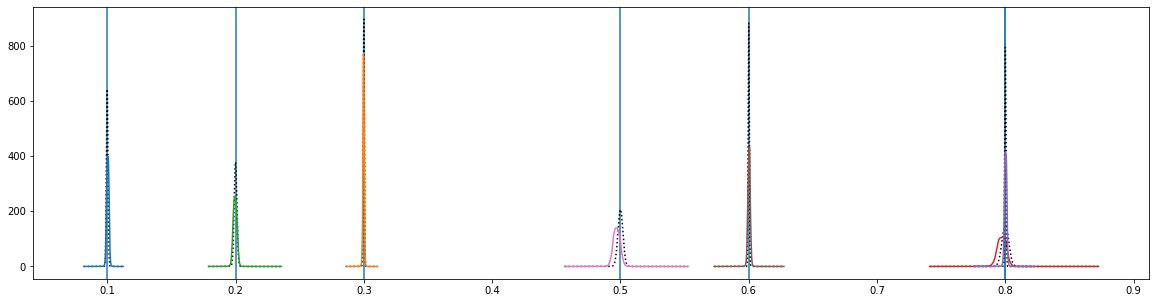

In [62]:
plt.figure(figsize=(20, 5))
for i in range(7):
    z, p = sw.posterior(i, version = -1)
    plt.axvline(z0[i])
    plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
#plt.xlim([0.79, 0.81])

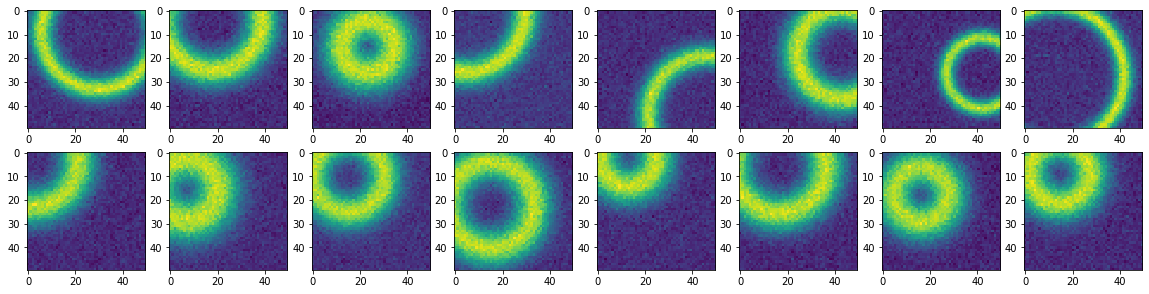

In [45]:
# Training data in different rounds (without noise)

plt.figure(figsize=(20, 10))
counter = 0
for r in range(len(sw.data_store)):
    imgs = swyft.get_x(sw.data_store[r])
    for i in range(8):
        counter += 1
        plt.subplot(4, 8, counter)
        plt.imshow(imgs[i])

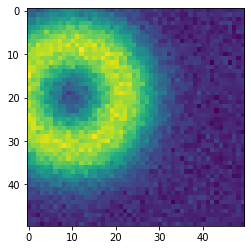

In [51]:
z1 = np.array([0.2, 0.4, 0.1, 0.7])
x1 = noisemodel(model(z1))
plt.imshow(x1)

In [52]:
# Instantiate network
sw2 = swyft.SWYFT(x1, model, datastore=sw.ds, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw2.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 2, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.: 100%|██████████| 9623/9623 [00:00<00:00, 25147.97it/s]


Extracted 2504 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 13
Validation losses: [9.954281270503998, 9.328139066696167, 8.458849132061005, 8.029880911111832, 7.52731728553772, 7.086339503526688, 6.757126867771149, 6.331210196018219, 5.935066133737564, 5.743392646312714, 5.659642070531845, 5.809897989034653, 6.1317819356918335]
LR iteration 1
Total epochs: 6
Validation losses: [5.038871794939041, 4.932774901390076, 4.991360053420067, 4.890425235033035, 4.964321345090866, 4.949502810835838]
LR iteration 2
Total epochs: 3
Validation losses: [4.841429501771927, 4.851963937282562, 4.869435280561447]


Adding samples.: 100%|██████████| 2501/2501 [00:00<00:00, 21427.00it/s]


Adding 1530 new samples.


Extracting samples.: 100%|██████████| 11153/11153 [00:00<00:00, 22729.86it/s]


Extracted 2485 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 9
Validation losses: [8.722793221473694, 6.849096834659576, 6.423257440328598, 5.974985182285309, 5.27606800198555, 5.071128398180008, 4.406280383467674, 4.780746713280678, 4.667681574821472]
LR iteration 1
Total epochs: 12
Validation losses: [3.546554997563362, 3.404864937067032, 3.3048183917999268, 3.1885317265987396, 3.085148796439171, 3.075990580022335, 3.0452656596899033, 2.9713824540376663, 2.9467071294784546, 2.8038237169384956, 2.89145115762949, 2.887333631515503]
LR iteration 2
Total epochs: 5
Validation losses: [2.842994876205921, 2.7778813540935516, 2.7597638815641403, 2.77317912876606, 2.773672968149185]
20.79352235396703


In [55]:
sw2.run(nworkers=0, nrounds = 2, max_epochs = 20, early_stopping_patience = 2, nsamples = 2500, nbatch = 32, recycle_net = False, threshold = 1e-8)

Adding samples.: 100%|██████████| 2443/2443 [00:00<00:00, 16684.53it/s]


Adding 2237 new samples.


Extracting samples.: 100%|██████████| 13390/13390 [00:00<00:00, 22910.62it/s]


Extracted 2434 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 6
Validation losses: [7.363262414932251, 5.430447429418564, 4.834895521402359, 4.30812032520771, 4.5179788917303085, 4.419874876737595]
LR iteration 1
Total epochs: 7
Validation losses: [3.229215234518051, 2.9552659168839455, 2.8320297598838806, 2.757541924715042, 2.6523366570472717, 2.6724623069167137, 2.7583843171596527]
LR iteration 2
Total epochs: 3
Validation losses: [2.5035981982946396, 2.633713312447071, 2.6545024886727333]


Adding samples.: 100%|██████████| 2430/2430 [00:00<00:00, 15360.19it/s]


Adding 2404 new samples.


Extracting samples.: 100%|██████████| 15794/15794 [00:00<00:00, 22307.28it/s]


Extracted 2437 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 8
Validation losses: [7.683135986328125, 5.778822064399719, 5.066813230514526, 4.96481192111969, 4.34365214407444, 3.8683915436267853, 4.094754800200462, 4.236411198973656]
LR iteration 1
Total epochs: 4
Validation losses: [3.107597529888153, 2.829168453812599, 2.9544200897216797, 2.859949305653572]
LR iteration 2
Total epochs: 10
Validation losses: [2.8155148774385452, 2.879644051194191, 2.7718603387475014, 2.798614725470543, 2.711457759141922, 2.7390183955430984, 2.700387053191662, 2.68730328977108, 2.7648016959428787, 2.6941352859139442]


In [56]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z1+dz) - model(z1))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00062705 0.00047934 0.0010436  0.00368207]


2.127753268874062 4.646645881718635
2.461130380804802 4.885396567250638
1.9181527327808554 4.31962522908101
1.7430996321235184 4.157679371140375


(-5, 400)

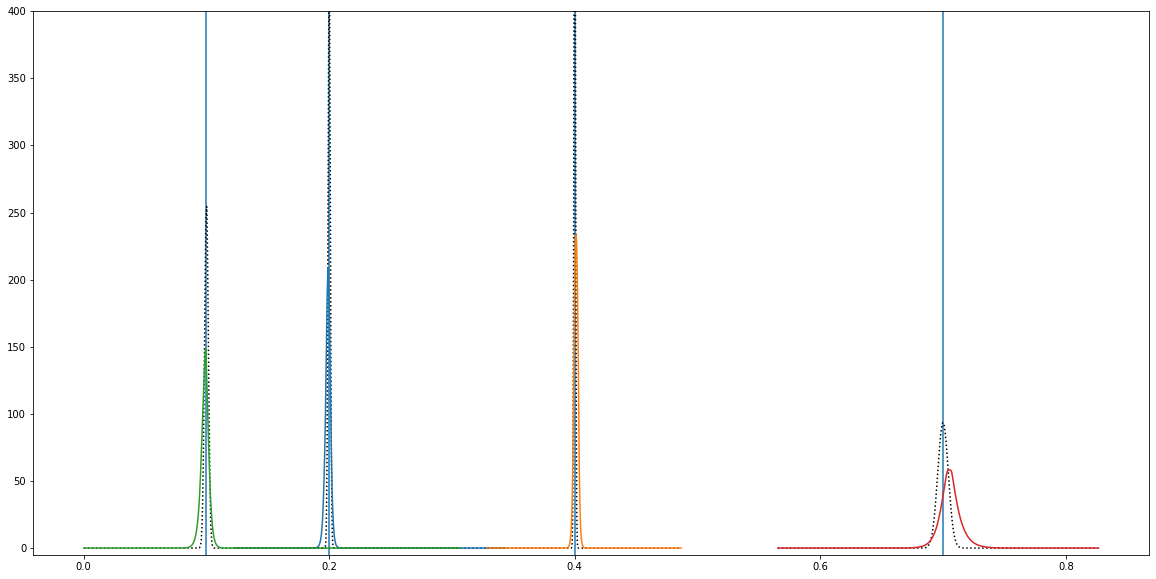

In [70]:
plt.figure(figsize=(20, 10))
for i in range(4):
    z, p = sw2.posterior(i, version = -2)
    plt.axvline(z1[i])
    plt.plot(z, stats.norm.pdf(z, z1[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
#plt.xlim([0.79, 0.81])
plt.ylim([-5,400])

# 2-dim plots

In [79]:
ch1=time.time()
sw.comb([[0, 1]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

Number of output features: 160
Start training
LR iteration 0
Total epochs: 72
Validation losses: [1.5503842753823847, 1.1389007274992764, 0.59413494868204, 0.6094657799694687, 0.6063730730675161, 0.9190390822477639, 0.497062147827819, 0.6230803120415658, 0.5573884811019525, 0.4936886342475191, 0.4389572482323274, 0.5585304626729339, 0.6765023298794404, 0.7049488944467157, 0.5229525030590594, 0.6756582070374861, 0.5492727110395208, 0.844024206395261, 0.6252374292816967, 0.4574083231855184, 0.5804524337290786, 1.062272246927023, 0.8322827499359846, 0.8090871304739267, 0.7348487300332636, 0.3810917604714632, 0.548162747756578, 0.4169215935980901, 0.48580981395207345, 0.39051971916342154, 1.19792664446868, 0.6538013098761439, 0.47332324378658086, 0.5005657002329826, 0.41422414884436876, 0.46699245972558856, 0.5374698351952247, 0.3291900342446752, 0.5171510186628439, 0.4952565807616338, 0.3439461115049198, 0.3850363950477913, 0.5748567542177625, 0.8187576388008893, 0.37316588032990694, 0.68

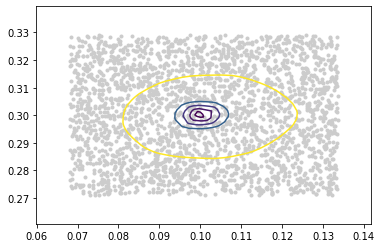

In [80]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [81]:
ch1=time.time()
sw.comb([[0, 2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

Number of output features: 160
Start training
LR iteration 0
Total epochs: 68
Validation losses: [1.1045640297234058, 1.6508182678371668, 1.1161789749749005, 0.552002162206918, 0.519239152316004, 0.577099414775148, 0.6692298769485205, 0.540311515564099, 0.45641182153485715, 1.2116371568990871, 0.5825109469005838, 0.4379720939323306, 1.2076766145182773, 0.4247101357905194, 0.5321204573847353, 0.43085010070353746, 0.3184164265403524, 0.51816911122296, 0.29104869585717097, 0.525380096398294, 0.39021048147697, 0.32859997311607003, 0.852203376183752, 0.5501761380583048, 0.5028100501513109, 0.41434283019043505, 0.39145732717588544, 0.2502100811107084, 0.36290097737219185, 0.5961363497190177, 0.32316780742257833, 0.3042778526432812, 0.3183023366727866, 0.3642667055828497, 0.6842161240056157, 0.3506630366900936, 0.24574844262679107, 0.9425929163116962, 0.4100370528176427, 0.4398202273878269, 0.2552635506144725, 0.26274896383984014, 0.29039682942675427, 0.29572134994668886, 0.2993427017936483, 

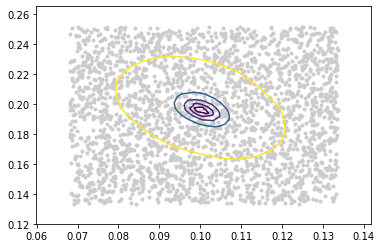

In [82]:
zgrid, lnLgrid = sw.posterior([0, 2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [83]:
ch1=time.time()
sw.comb([[0, 3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

Number of output features: 160
Start training
LR iteration 0
Total epochs: 37
Validation losses: [1.6198520818725228, 1.0067319758236408, 0.5981043335050344, 0.6361539321951568, 1.2155826673842967, 0.733263703994453, 0.46369906689506024, 0.4383107703179121, 0.5498240543529391, 0.6233516589272767, 0.5814671695698053, 0.48884144879411906, 0.4173893735278398, 0.41927986254449934, 0.38931298069655895, 0.5235972529626451, 0.2520717046572827, 0.32427584507968277, 0.507171890232712, 0.5256546376040205, 0.3639501859433949, 0.5309164714999497, 0.4243602209025994, 0.47472389065660536, 0.3563191082794219, 0.4605066734366119, 0.37560656445566565, 0.344751124503091, 0.38091839029220864, 0.2898411356145516, 0.38198574155103415, 0.3865772874560207, 0.3671189524466172, 0.5122901216382161, 0.3776938326191157, 0.3659719172283076, 0.39143601327668875]
LR iteration 1
Total epochs: 31
Validation losses: [0.2360348120564595, 0.17715191302704625, 0.244820751453517, 0.22536084891180508, 0.25681906097452156, 0

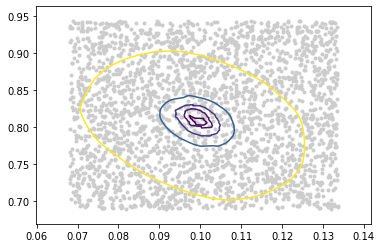

In [84]:
zgrid, lnLgrid = sw.posterior([0, 3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [85]:
ch1=time.time()
sw.comb([[1,2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

Number of output features: 160
Start training
LR iteration 0
Total epochs: 41
Validation losses: [1.612661555991508, 1.10809530550614, 1.1392585879657418, 1.2210049896966666, 0.8073984473594464, 1.066716775414534, 0.6930033495300449, 1.083646011655219, 0.7722213921369985, 0.8507624348276295, 0.7628649563994259, 0.7144583252957091, 0.9485545340867247, 0.9145175560261123, 0.878998055588454, 0.8981698497082107, 0.8648903149878606, 0.95471255161101, 0.7247859184280969, 0.915756068425253, 0.5214493505482096, 1.2020029405830428, 0.9285672930709552, 1.0478707646834664, 0.7294569222722203, 0.6288023414090276, 0.6357876138063148, 0.8373930626548827, 0.6943268926115707, 0.7508213302935474, 0.7759641692973673, 0.7416164353198837, 0.6015319931902923, 0.7136856181896292, 0.597285883850418, 0.5916659064241685, 0.7577247597509995, 0.6975508517352864, 0.8117684010358062, 0.6744344648905098, 0.5598209649906494]
LR iteration 1
Total epochs: 34
Validation losses: [0.429175142373424, 0.41736536083044484, 

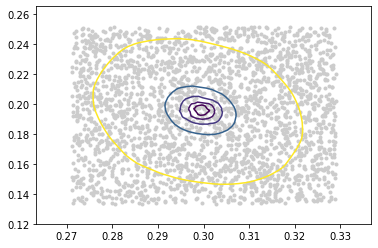

In [86]:
zgrid, lnLgrid = sw.posterior([1,2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[1,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

Number of output features: 160
Start training
LR iteration 0


In [ ]:
zgrid, lnLgrid = sw.posterior([1,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[2,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([2,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])